In [2]:
# Load csv data

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import json
import spacy 
from spacy.matcher import Matcher
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

filepath = os.path.join(os.getcwd(), 'QueryResults_sample.csv')

stack_posts = pd.read_csv(filepath, sep = ",")
    
print("loaded csv data")

loaded csv data


In [36]:
# count answer user
# not used yet
user_Counter = Counter(stack_posts["AnswerUserId"])

user_experts = Counter({k: c for k,c in user_Counter.items()})
user_experts_df = pd.DataFrame.from_dict(user_experts, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False).nlargest(n=10, columns="Häufigkeit")
user_experts_df

,Häufigkeit
1190430,8
1330293,7
419338,4
4370183,4
628538,2
1060350,2
1409938,1
492372,1
1078601,1
570918,1


In [4]:
# clean posts and match words
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

pattern = [{'POS': 'ADJ', 'OP': '?'},
           {'OP': '+', 'POS': 'NOUN'},
           {'POS': 'NOUN', 'OP': '?'}
          ]

wordlist = []

for text in stack_posts["AnswerBody"]:                   
    text = re.sub('<pre(.|\n)*?/pre>|<code>(.|\n)*?</code>|(<a(.*|\n)a>)|(<(p|\/p|br|sub|\/sub|em|\/em)>)', '', text)        
    
    doc = nlp(text)

    matcher.add("match_nouns", [pattern])
    matches = matcher(doc)
    for match_id, start, end in matches:
        wordlist.append(doc[start:end].text)       

c = Counter(wordlist)
print("finished")

finished


Text(0, 0.5, 'Häufigkeit')

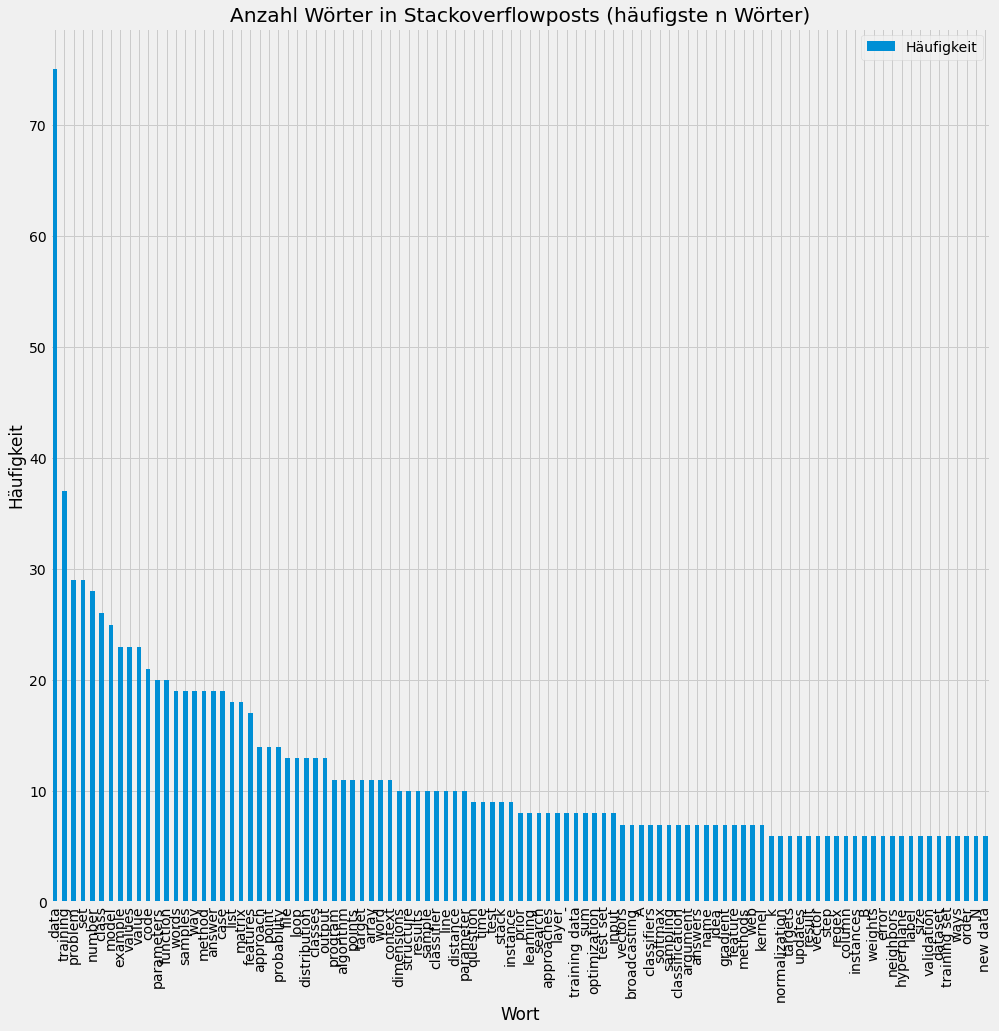

In [97]:
# load words in counter and get n most_common words

#words with x quantity
x = 5
n = 25

counter_bigger_than = Counter({k: c for k,c in c.items() if c > x}) 

word_counter_df = pd.DataFrame.from_dict(counter_bigger_than, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False) #.nlargest(n=n, columns="Häufigkeit")

plt.style.use('fivethirtyeight')

figure = word_counter_df.plot(kind = 'bar', figsize=(15, 15), )
figure.set_title('Anzahl Wörter in Stackoverflowposts (häufigste n Wörter)')
figure.set_xlabel("Wort")
figure.set_ylabel("Häufigkeit")

In [144]:
# 
test_text = stack_posts["AnswerBody"][:10]

text_list = []
for reg_text in test_text:    
    reg_text = re.sub('<pre(.|\n)*?/pre>|<code>(.|\n)*?</code>|(<a(.*|\n)a>)|(<(p|\/p|br|sub|\/sub|em|\/em)>|\n)', '', reg_text)  
    text_list.append(reg_text)


vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.01)
test_vectorizer = vectorizer.fit_transform(text_list)


tdm = []
tdm_column_labels = []
answer_ids = stack_posts[["AnswerUserId", "AnswerId"]][0:10]
# loop through spacy word list
for i, j in word_counter_df.iterrows():
    
    # check if spacy word is in vectorizer 
    if i in vectorizer.vocabulary_.keys():
        if len(tdm) >= 20:
            break
        tdm.append(test_vectorizer.toarray()[:,vectorizer.vocabulary_[i]].tolist())
        tdm_column_labels.append(i)

print(test_vectorizer.toarray()[:,vectorizer.vocabulary_["data"]].tolist())
        
tdm_df = pd.DataFrame(tdm)
tdm_df = tdm_df.transpose()
tdm_df.columns = tdm_column_labels
tdm_df.set_index([answer_ids["AnswerUserId"], answer_ids["AnswerId"]], inplace=True)
tdm_df

[0.0, 0.0, 0.0, 0.0, 0.12737099142964728, 0.0, 0.0, 0.2110549943217136, 0.0, 0.0]


,,data,training,problem,set,model,example,values,value,code,function,answer,case,matrix,features,approach,point,classes,output,results,classifier
AnswerUserId,AnswerId,,,,,,,,,,,,,,,,,,,,
1056563,27733517,0.000000,0.000000,0.000000,0.147132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168173
173355,27808712,0.000000,0.000000,0.000000,0.000000,0.277359,0.158513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186465,0.000000
367273,27730829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4674497,36767722,0.000000,0.070717,0.000000,0.000000,0.088570,0.000000,0.000000,0.000000,0.101236,0.000000,0.119089,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2220275,36917856,0.127371,0.029658,0.074290,0.000000,0.222869,0.084914,0.000000,0.000000,0.000000,0.042457,0.000000,0.099888,0.24972,0.099888,0.042457,0.000000,0.000000,0.000000,0.000000,0.000000
1190430,27739386,0.000000,0.069177,0.000000,0.000000,0.000000,0.000000,0.000000,0.099032,0.000000,0.198064,0.000000,0.000000,0.00000,0.000000,0.000000,0.116495,0.116495,0.000000,0.000000,0.000000
4408281,27744808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1361822,27745227,0.211055,0.073715,0.184648,0.184648,0.000000,0.000000,0.000000,0.105527,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.105527,0.000000,0.000000,0.000000,0.000000,0.105527
419338,27753656,0.000000,0.255031,0.000000,0.159706,0.000000,0.000000,0.214737,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.214737,0.000000,0.000000
